# Experiment 1: Do V20 lake fields improve our predicitions?

We compare two models:

* A model using time variable features + `v15_cl`
* A model using time variable features + `v15_cl` + `V20 correction`

The correction is obtained by calculating `v20_cl - v15_cl`.

---


# A. How does lake cover change going from V15 to V20?

Before looking at the model results, it is worth having a quick look at how the lake cover parameter `cl` (see [here](https://apps.ecmwf.int/codes/grib/param-db/?id=26)) is updated when we go from V15 to V20. See also `A1.V20_vs_V15.ipynb` in this directory.




In [57]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.colors as mc
import matplotlib.colorbar as cb 




def correct_longitude(ds):    
    return ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})


def plot_map(ds,z,vmin,vmax,cmap,logscale,title):
    
    """Scatter plot. Bit hacky. """

    try:
        x = ds.longitude
        y = ds.latitude
    except: #different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=1,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)
    
    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    

    plt.show()
    

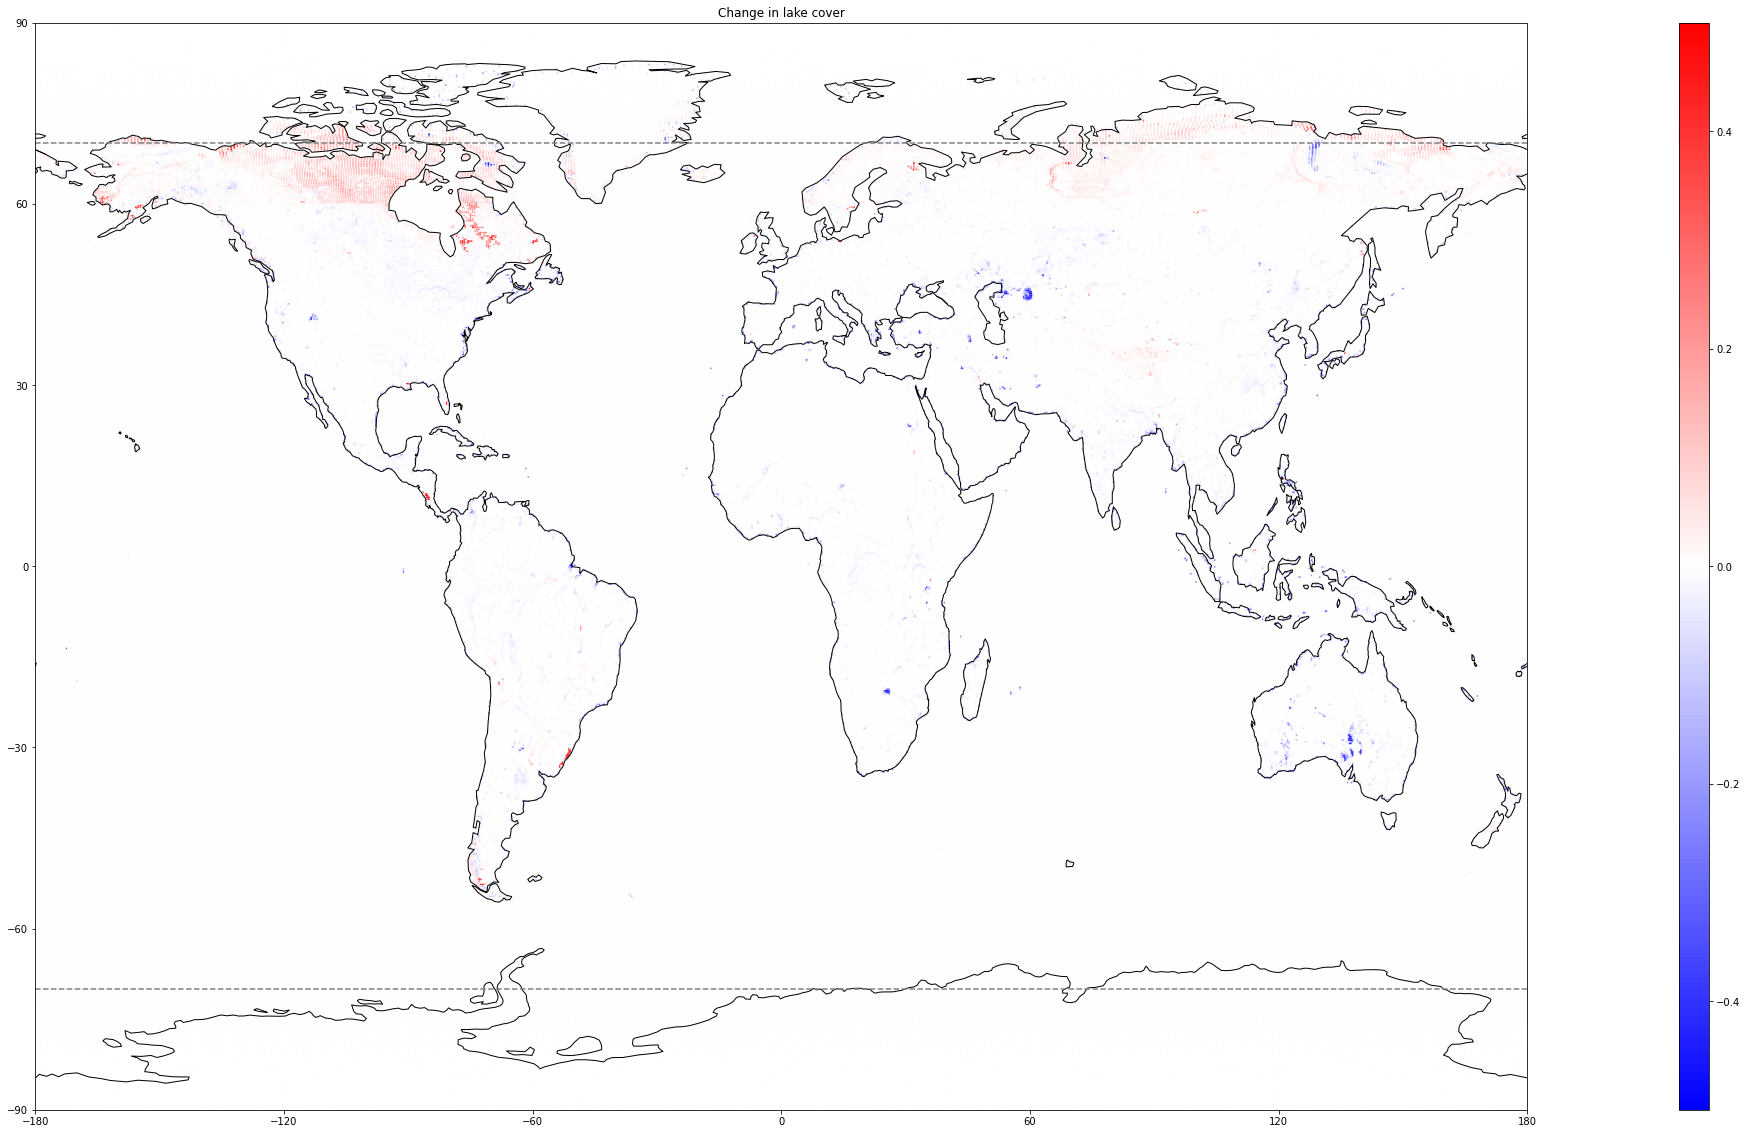

In [41]:

#Setup
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
version = ['v015', 'v020']



ds = [] #Array to hold results
for v in version:
    clake_path = root+f'climate.{v}/climate.{v}/639l_2/clake'
    ds_i= xr.open_dataset(clake_path,engine='cfgrib',backend_kwargs={'indexpath': ''}) 
    ds.append(ds_i)

#Take the difference    
delta = ds[1] - ds[0] #V20 - V15
delta = correct_longitude(delta) #long3 ---> long1

#Plot it
plot_map(delta,'cl',vmin=-0.5,vmax=+0.5,cmap=plt.cm.bwr,logscale=False,title='Change in lake cover')

#We can also blow up the scale:
#plot_xr_map(delta,'cl',vmin=1e-5,vmax=1,cmap=plt.cm.magma,logscale=True)


We can see that the siginificant modifications to the lake cover happen in a few key areas.


---

# B. How does this extra information influence the model?


Ok we now have seen how the `cl` feature is changing. If we pass this extra information to the model, does it improve our predictions?

In [61]:
import pandas as pd
import json
import numpy as np

def load_predictions(path):

    df = pd.read_pickle(path+'predictions.pkl')
    df['model_error'] = df.MODIS_LST - df.predictions
    df['absolute_model_error'] = abs(df.MODIS_LST - df.predictions)

    
    return df

def plot_training_history(path,logscale,jump_n_epochs):
    
    with open(path+'meta.txt') as f:
        lines = f.readlines()
        print(*lines)
        #print( [row for row in lines])
    
    
    
    
    with open(path+'history.json') as f:
        d = json.load(f)

        i = jump_n_epochs
        training_loss = d['loss'][i:]
        epochs = np.arange(len(training_loss))
        
        

        

        fig = plt.figure(figsize=(10, 10))
        plt.plot(epochs,training_loss,label='training loss')
        try:
            validation_loss = d['val_loss'][i:]
            plt.plot(epochs,validation_loss, label='validation loss')
        except:
            pass
        plt.legend()
        
        if logscale:
            plt.yscale('log')


input_file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/all_months.h5
 train_condition: 2019-01-01 00:00:00
 test_condition: 2020-01-01 00:00:00
 epochs: 100
 batch_size: 10000
 features: ['sp', 'msl', 'u10', 'v10', 't2m', 'aluvp', 'aluvd', 'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m', 'fal', 'skt', 'cl_v15']
 optimizer: adam

input_file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/all_months.h5
 train_condition: 2019-01-01 00:00:00
 test_condition: 2020-01-01 00:00:00
 epochs: 100
 batch_size: 10000
 features: ['sp', 'msl', 'u10', 'v10', 't2m', 'aluvp', 'aluvd', 'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m', 'fal', 'skt', 'cl_v15', 'cl_delta']
 optimizer: adam



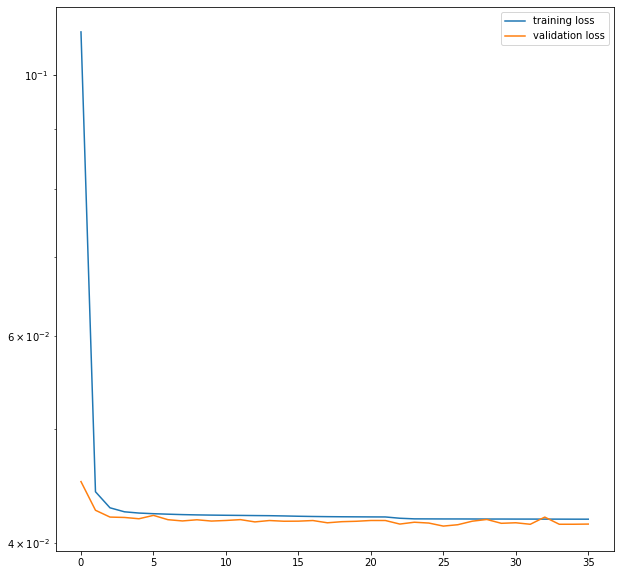

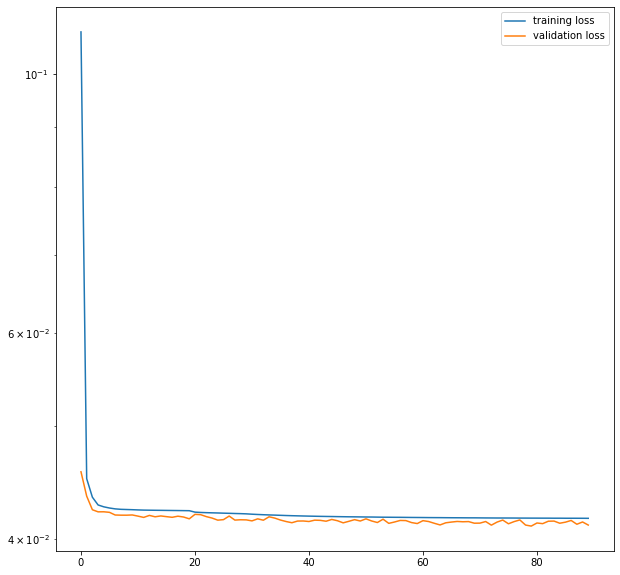

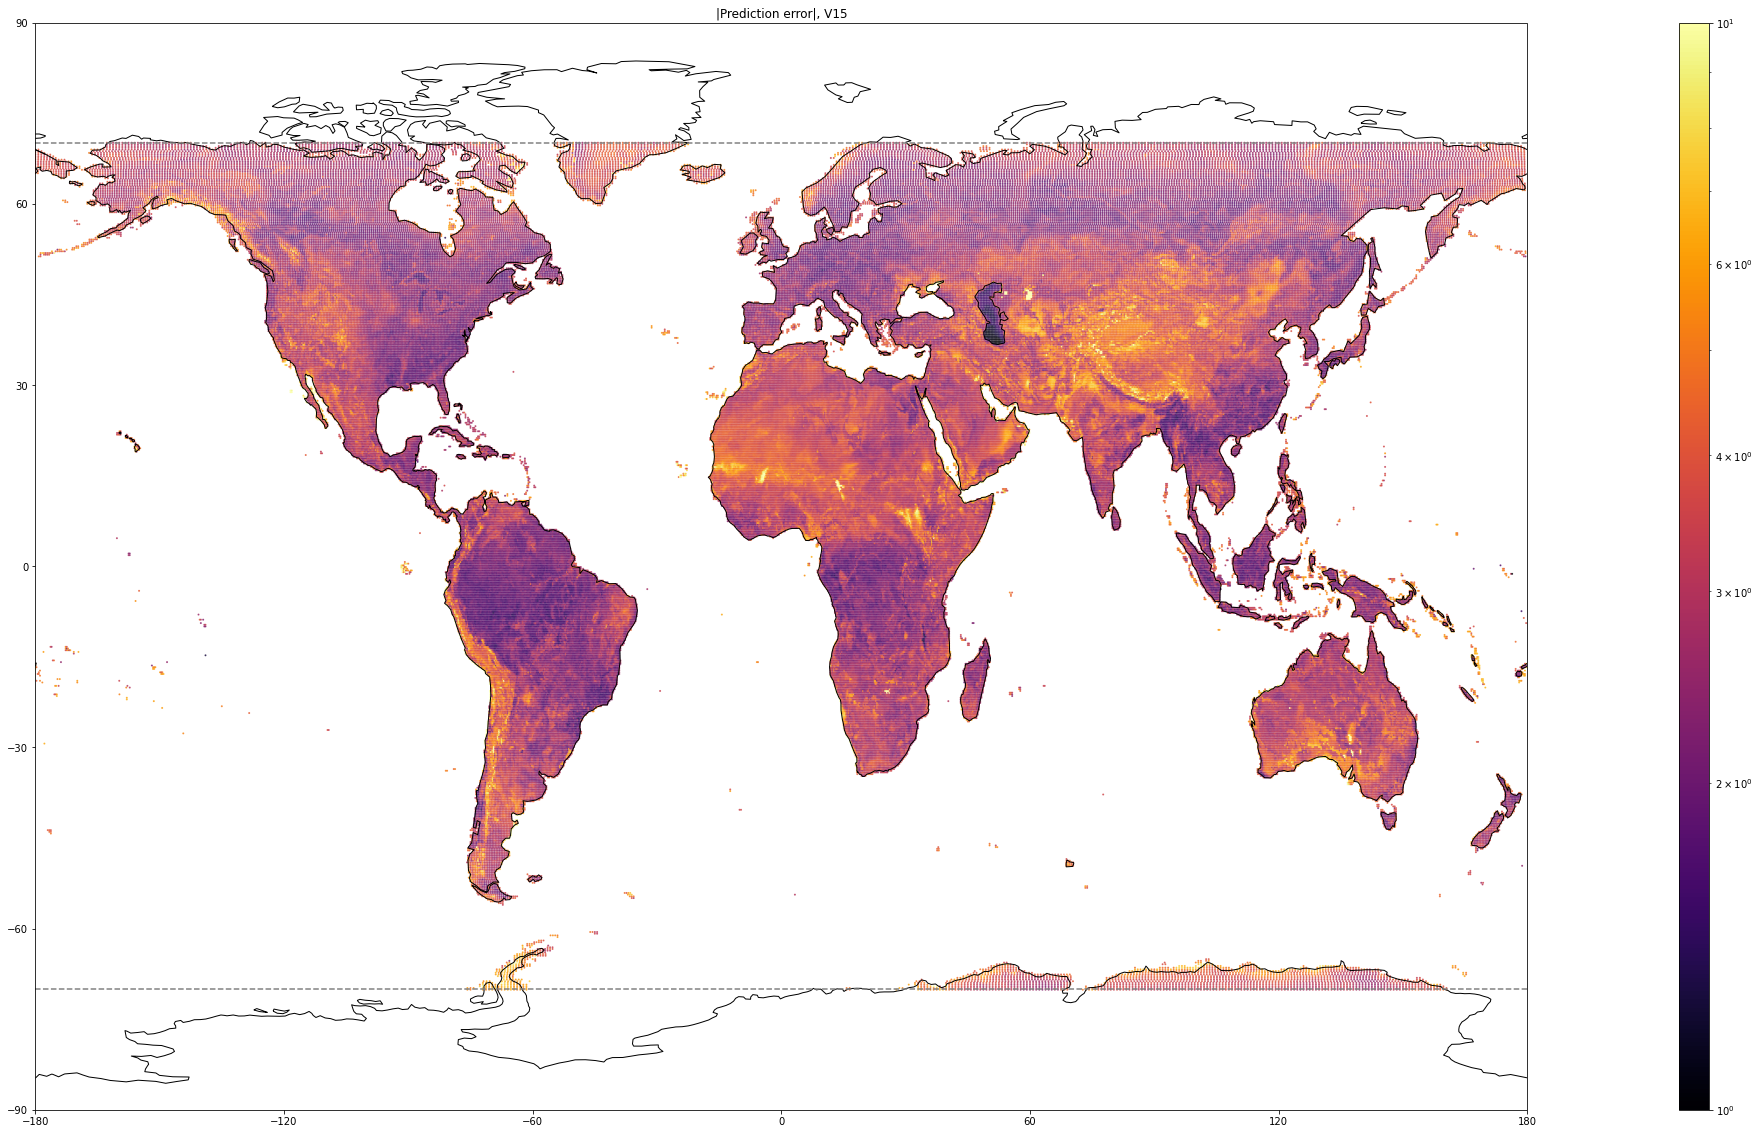

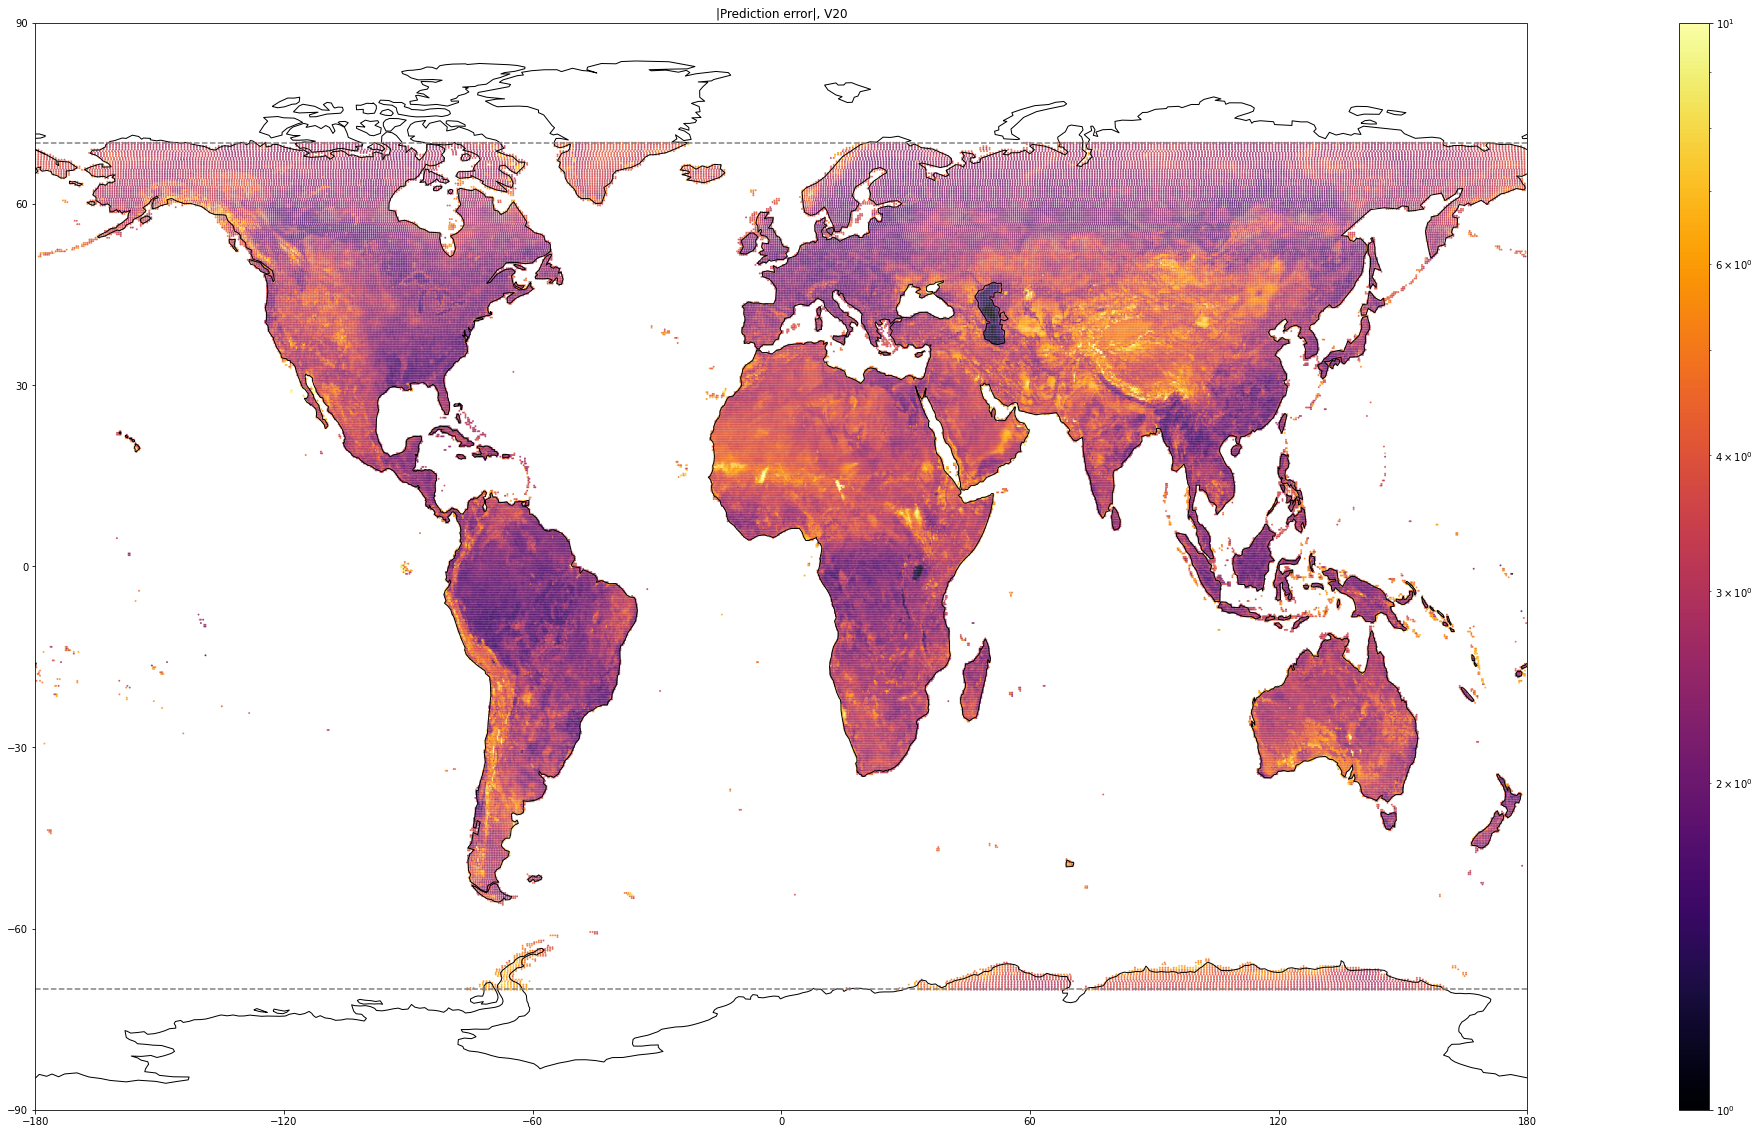

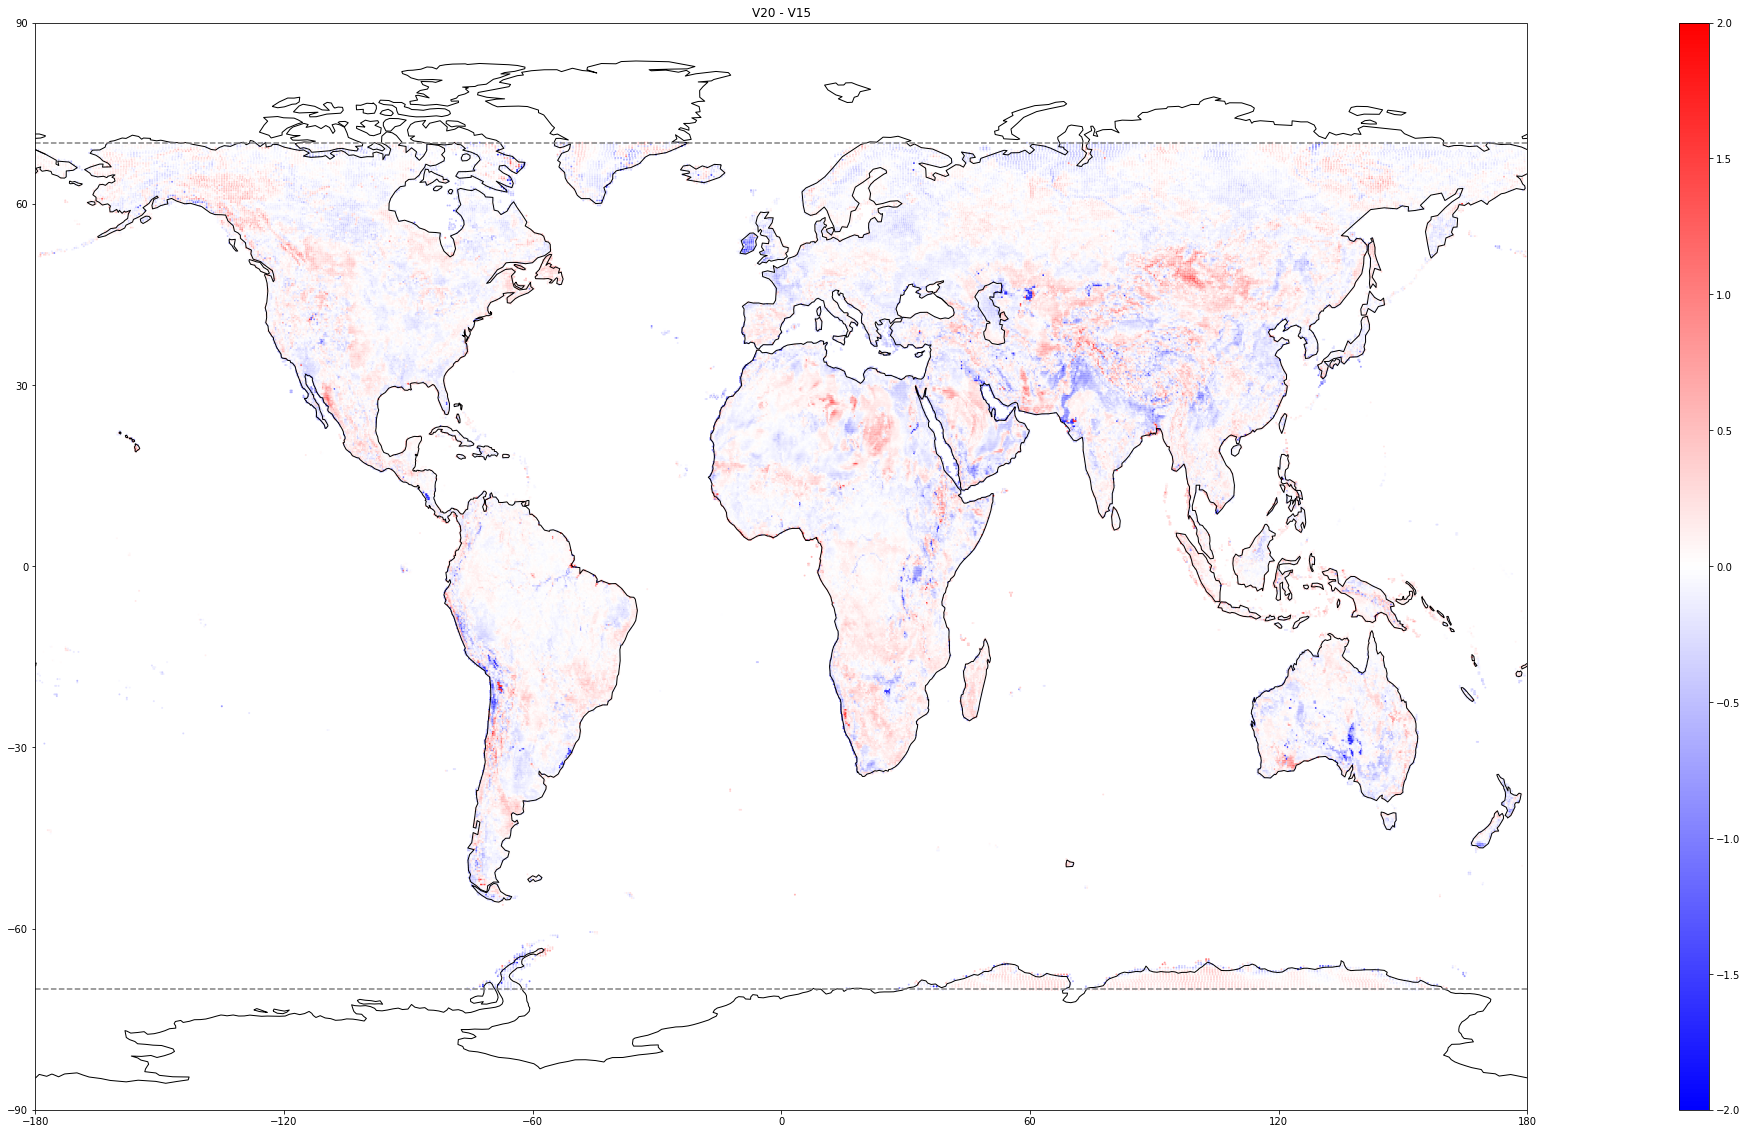

In [70]:


#Parameters
models_root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/'
modelV15 = 'ML_bfb2864d71084be48f31aa7c7eed2cce/' 
modelV20 = 'ML_d5314d4d6a0b411095f941f178907e5e/' 
    
cmap = plt.cm.inferno
logscale = True #None
vmin = 1
vmax = 10


#Process 
V15 = load_predictions(models_root+modelV15) #Load data
V15_grouped = V15.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() #averagee predictions over the year


V20 = load_predictions(models_root+modelV20)
V20_grouped = V20.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()
    
    
    
#Plot training history for interest
plot_training_history(models_root+modelV15,logscale=True,jump_n_epochs=0) 
plot_training_history(models_root+modelV20,logscale=True,jump_n_epochs=0)
    
    
#Plot the map of the prediction error    
plot_map(V15_grouped,'absolute_model_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V15')
plot_map(V20_grouped,'absolute_model_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V20')

    
#Create a new df that will just hold the differences, and plot it    
data = {'latitude_ERA':V20_grouped.latitude_ERA, 
        'longitude_ERA':V20_grouped.longitude_ERA,
         'delta':V20_grouped.absolute_model_error - V15_grouped.absolute_model_error}
df_delta = pd.DataFrame(data)    
plot_map(df_delta,'delta',vmin=-2,vmax=+2,cmap=plt.cm.bwr,logscale=False,title='V20 - V15')

    
    



From this map it is hard to disentangle regions of improvement over the inherent variability due to the stochasticity of training the model.

What we can do is **apply a mask to isolate just those regions where cl has been changed appreciably**

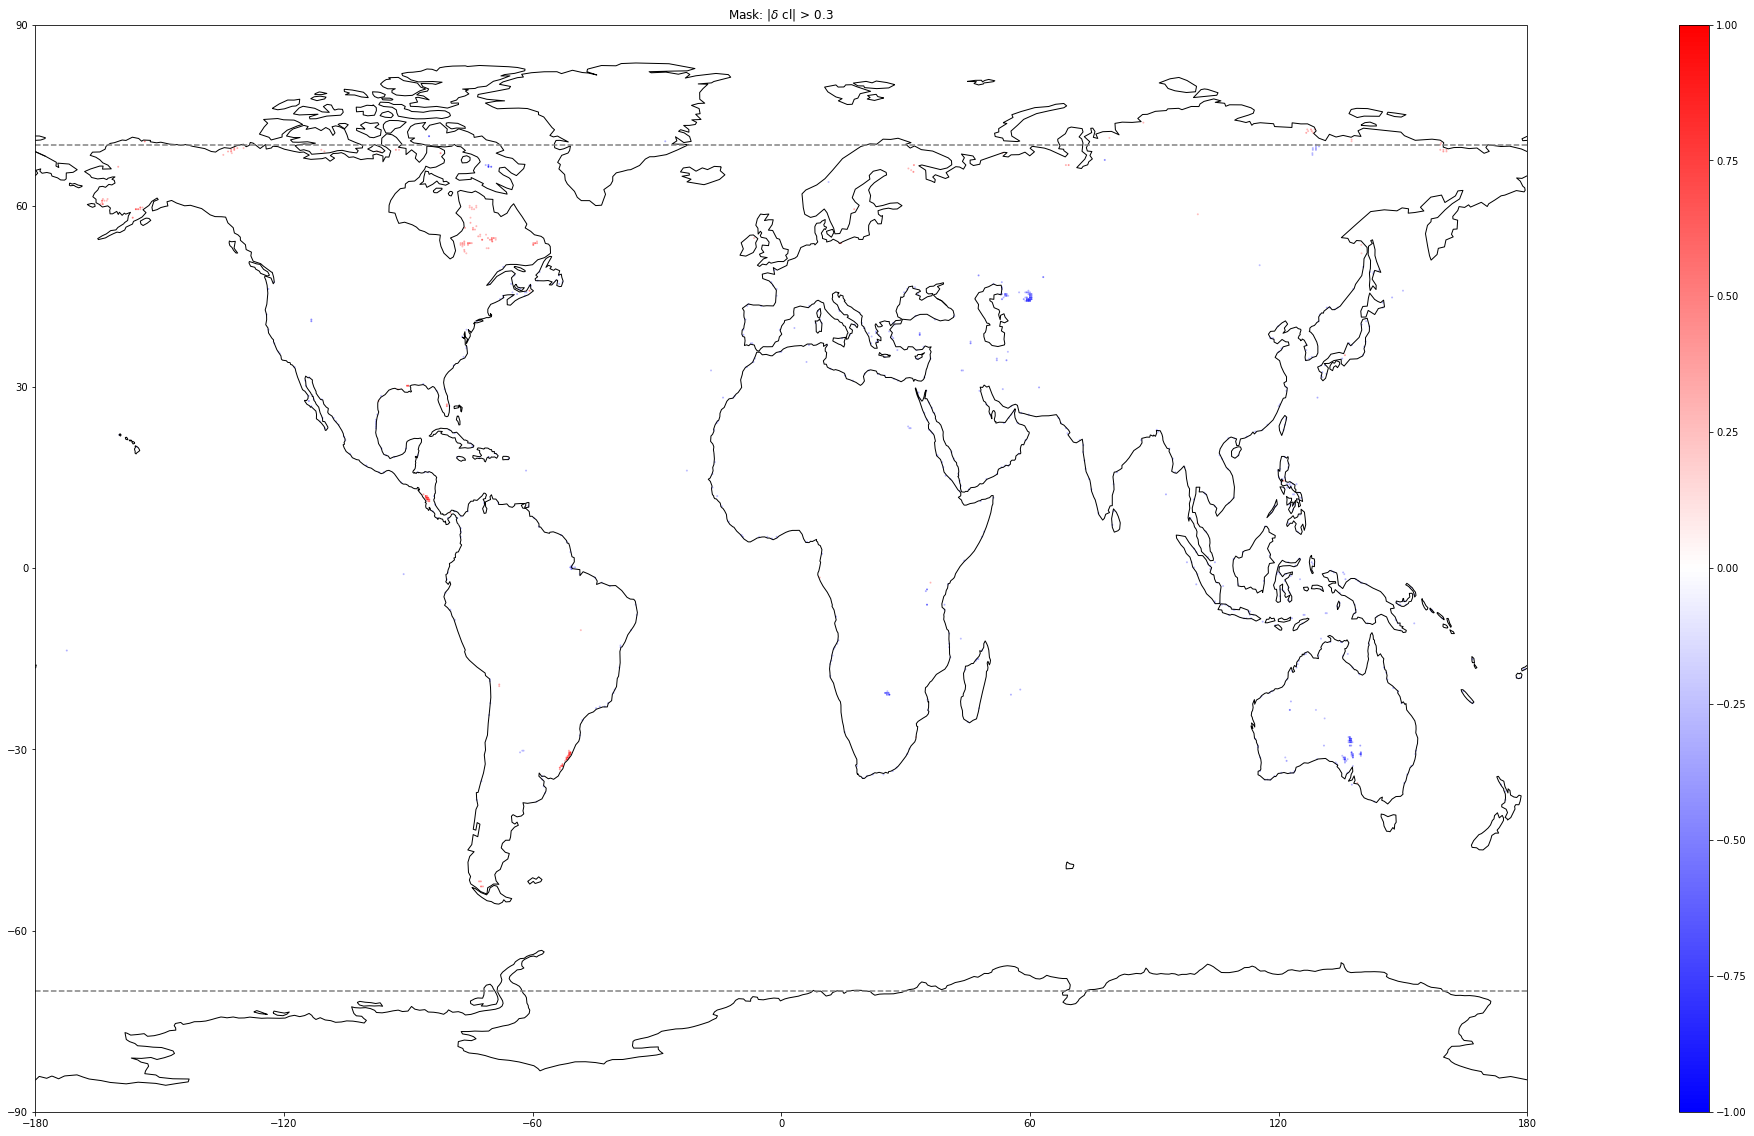

In [94]:
mask = delta.to_dataframe().reset_index() #delta is V20 cl - V15 cl that we defined in section A
p = 0.3 # cutoff paramter
mask = mask[abs(mask.cl) > p] #Only get the points where cl changed by > 0.3. What is a reasonable value for this variable?
plot_map(mask,'cl',vmin=-1,vmax=+1,cmap=plt.cm.bwr,logscale=False,title=f'Mask: |${{\delta}}$ cl| > {p}') #What does this mask look like?

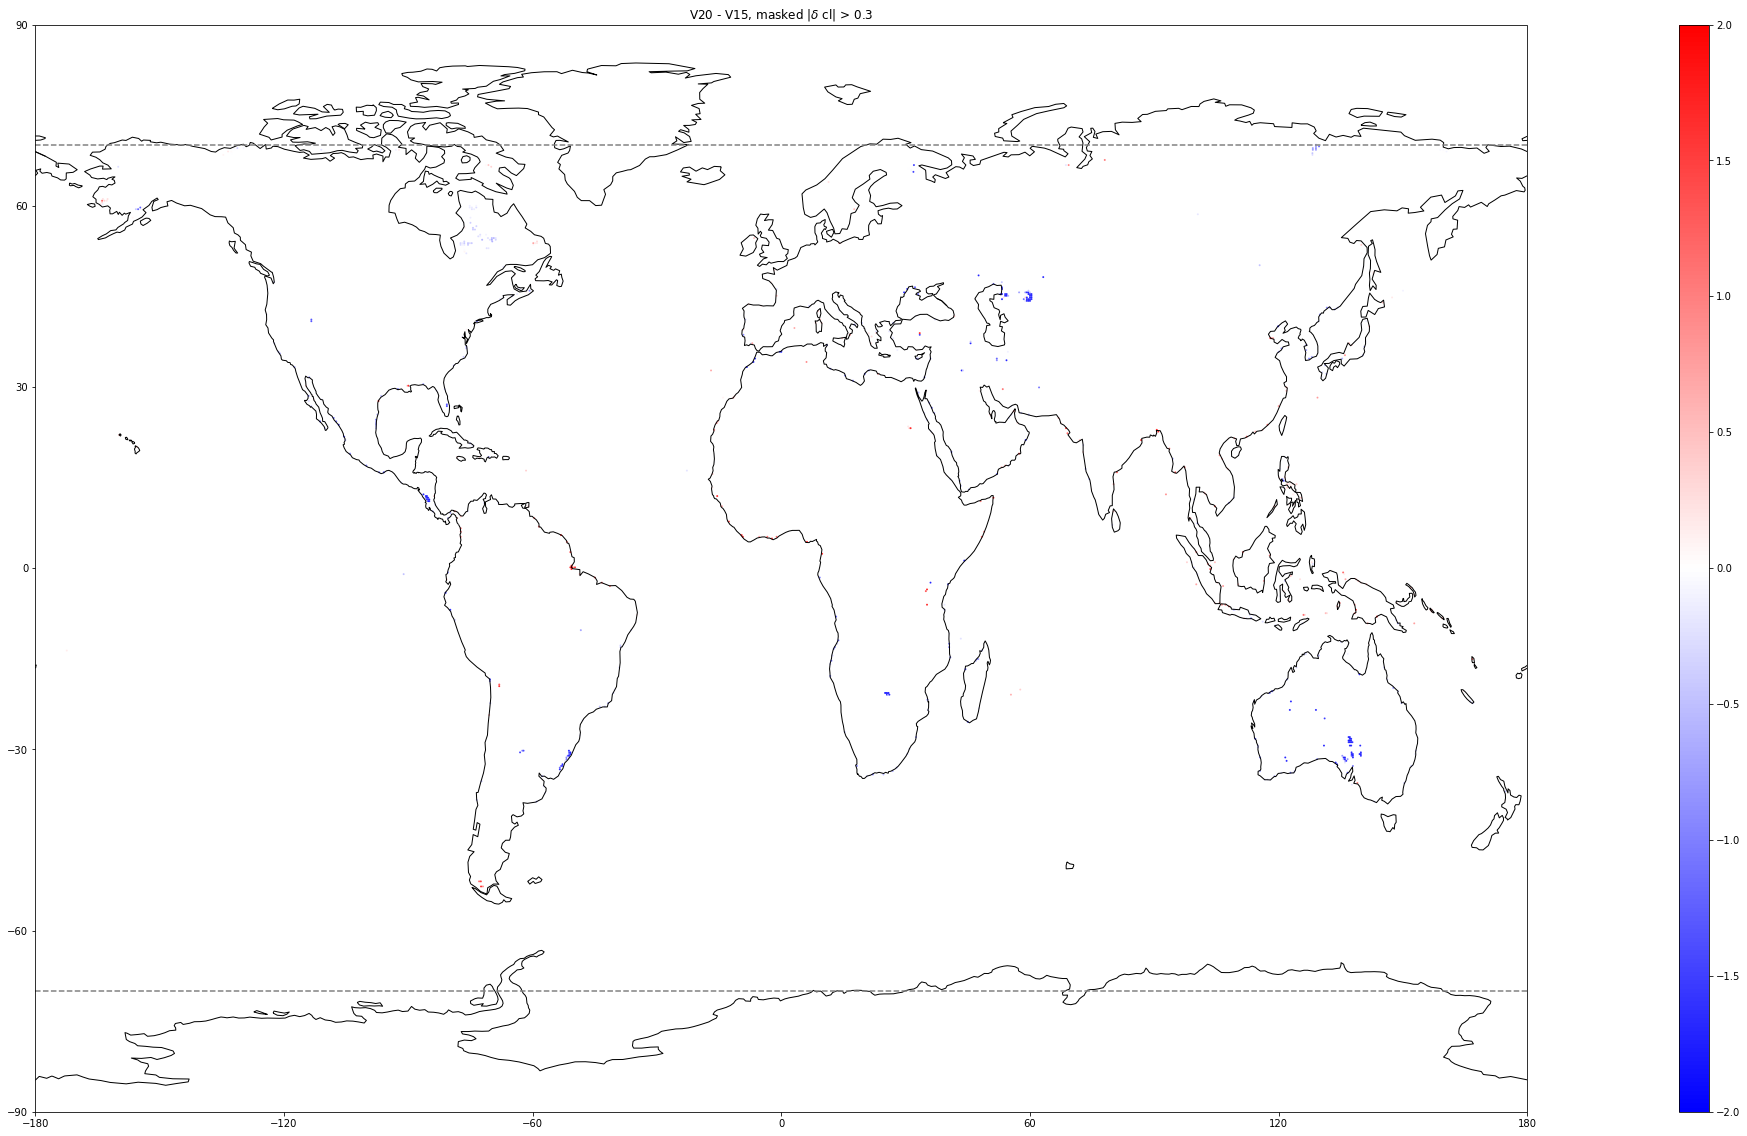

In [90]:
df_delta_masked = pd.merge(df_delta,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude'])
plot_map(df_delta_masked,'delta',vmin=-2,vmax=+2,cmap=plt.cm.bwr,logscale=False,title=f'V20 - V15, masked |${{\delta}}$ cl| > {p}')


In [108]:
df_delta_masked.delta.mean()

-0.52224064

Note:
* Blues = good. This means that the error in V15 is greater than the error in V20.

# Appendix

Alternatively, we can try to deal with the variability by doing an ensemble of runs



In [97]:
# Y1 ML_3c5196d3c1b14c549fc9738d81fd119d
# Y2 ML_9762b34bc3654484b6943b23d5ba6b71
# Y3 ML_687b980f30e0461d8aed0bc45bf0ab09
# Y4 ML_1f4f91422e5a4498ba3800fe6d370f18


# N1 ML_b55712df9ea7473e8580b30121a28130
# N2 ML_5164cbd6664948878ad4667364b2d570
# N3 ML_4512b6722899431683f5e873950bf047
# N4 ML_2f23f9bcf4d54d23aaf8a01774b571ee



V20_models = ['ML_3c5196d3c1b14c549fc9738d81fd119d/','ML_9762b34bc3654484b6943b23d5ba6b71/','ML_687b980f30e0461d8aed0bc45bf0ab09/','ML_1f4f91422e5a4498ba3800fe6d370f18/']
V15_models = ['ML_b55712df9ea7473e8580b30121a28130/','ML_5164cbd6664948878ad4667364b2d570/','ML_4512b6722899431683f5e873950bf047/','ML_2f23f9bcf4d54d23aaf8a01774b571ee/']

dfs = []
counter = 1
for a in V20_models:
    for b in V15_models:
        
        print (counter, a,b)
        V15 = load_predictions(models_root+b) #Load data
        V15_grouped = V15.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() #averagee predictions over the year
        
        
        V20 = load_predictions(models_root+a)
        V20_grouped = V20.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()
        
        
        #Create a new df that will just hold the differences 
        data = {'latitude_ERA':V20_grouped.latitude_ERA, 
                'longitude_ERA':V20_grouped.longitude_ERA,
                 'delta':V20_grouped.absolute_model_error - V15_grouped.absolute_model_error}
        df= pd.DataFrame(data)
        
        dfs.append(df)
        counter += 1

1 ML_3c5196d3c1b14c549fc9738d81fd119d/ ML_b55712df9ea7473e8580b30121a28130/
2 ML_3c5196d3c1b14c549fc9738d81fd119d/ ML_5164cbd6664948878ad4667364b2d570/
3 ML_3c5196d3c1b14c549fc9738d81fd119d/ ML_4512b6722899431683f5e873950bf047/
4 ML_3c5196d3c1b14c549fc9738d81fd119d/ ML_2f23f9bcf4d54d23aaf8a01774b571ee/
5 ML_9762b34bc3654484b6943b23d5ba6b71/ ML_b55712df9ea7473e8580b30121a28130/
6 ML_9762b34bc3654484b6943b23d5ba6b71/ ML_5164cbd6664948878ad4667364b2d570/
7 ML_9762b34bc3654484b6943b23d5ba6b71/ ML_4512b6722899431683f5e873950bf047/
8 ML_9762b34bc3654484b6943b23d5ba6b71/ ML_2f23f9bcf4d54d23aaf8a01774b571ee/
9 ML_687b980f30e0461d8aed0bc45bf0ab09/ ML_b55712df9ea7473e8580b30121a28130/
10 ML_687b980f30e0461d8aed0bc45bf0ab09/ ML_5164cbd6664948878ad4667364b2d570/
11 ML_687b980f30e0461d8aed0bc45bf0ab09/ ML_4512b6722899431683f5e873950bf047/
12 ML_687b980f30e0461d8aed0bc45bf0ab09/ ML_2f23f9bcf4d54d23aaf8a01774b571ee/
13 ML_1f4f91422e5a4498ba3800fe6d370f18/ ML_b55712df9ea7473e8580b30121a28130/
14 ML_1f

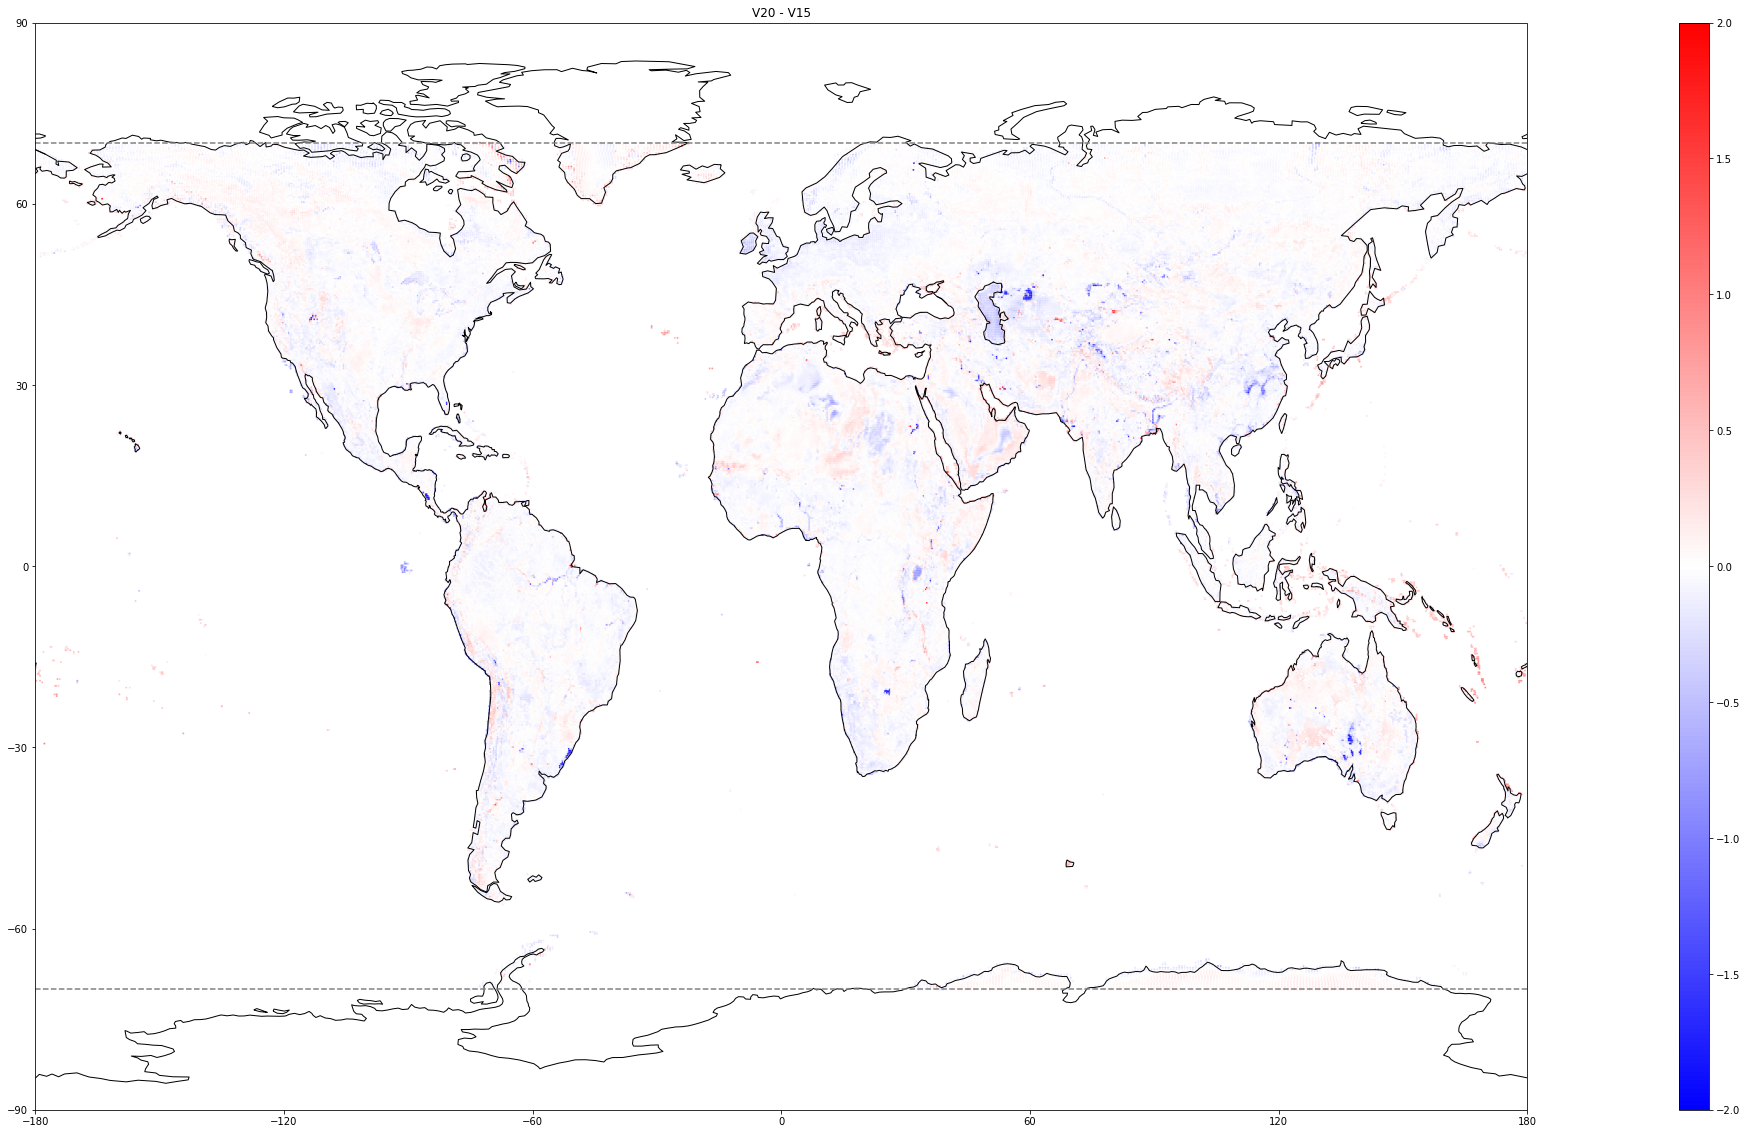

In [105]:
df_concat = pd.concat(dfs)
df_concat_grouped = df_concat.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()
plot_map(df_concat_grouped,'delta',vmin=-2,vmax=+2,cmap=plt.cm.bwr,logscale=False,title='V20 - V15')
